<a href="https://colab.research.google.com/github/santiagorg2401/pytorch_course_exercises/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. Custom Datasets
* TorchVision
* TorchAudio
* TorchText
* TorchRec
* TorchData

In [42]:
import os
import torch
import random
import zipfile
import requests
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from typing import Tuple, List, Dict
from torch.utils.data import DataLoader
from timeit import default_timer as timer
from torchvision import datasets, transforms

try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

SEED = 42
BATCH_SIZE = 32

print(f"PyTorch Version: {torch.__version__}")

# Set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} on PyTorch version {torch.__version__}")

PyTorch Version: 2.3.1+cu121
Using cuda on PyTorch version 2.3.1+cu121


## 0. Data processing

### 1. Get dataset

In [2]:
# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory alreedy exists ... skipping download")
else:
  print(f"{image_path} does not exist, creating one ...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_shushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data ...")
  f.write(request.content)

# Unzip
with zipfile.ZipFile(data_path / "pizza_steak_shushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, sushi data ...")
  zip_ref.extractall(image_path)

# Remove zip file
os.remove(data_path / "pizza_steak_shushi.zip")

data/pizza_steak_sushi does not exist, creating one ...
Unzipping pizza, steak, sushi data ...


### 1. Visualize dataset

In [3]:
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [4]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi


In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Image class: sushi
Image height: 382
Image width: 512


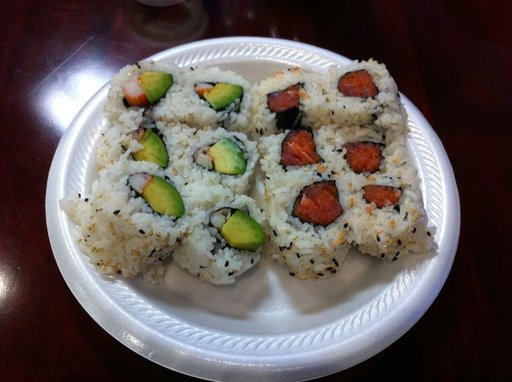

In [6]:
random.seed(SEED)

# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Pick a random image
ran_img_path = random.choice(image_path_list)
img_class = ran_img_path.parent.stem
img = Image.open(ran_img_path)

# Print metadata
print(f"Image class: {img_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

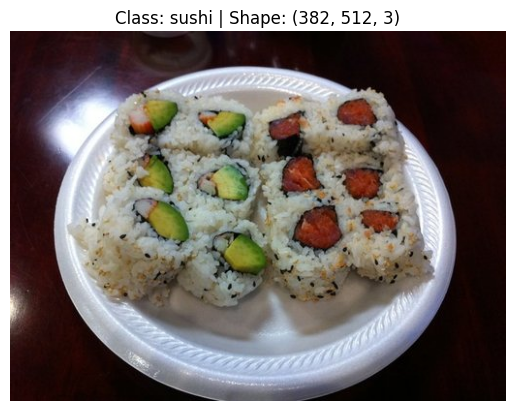

In [7]:
img_as_arr = np.array(img)
plt.figure()
plt.imshow(img_as_arr)
plt.title(f"Class: {img_class} | Shape: {img_as_arr.shape}")
plt.axis(False);

### 2. Use Pytorch Datasets

In [8]:
# Create an image transform
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [9]:
def plot_transformed_images(img_paths, transform, n=2, seed=42):
  if seed:
    random.seed(seed)
  random_img_paths = random.sample(img_paths, k=n)
  for img_path in random_img_paths:
    with Image.open(img_path)as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize:{f.size}")
      ax[0].axis(False)

      trans_img = transform(f).permute(1, 2, 0)
      ax[1].imshow(trans_img)
      ax[1].set_title(f"Transformed\nShape: {trans_img.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {img_path.parent.stem}")

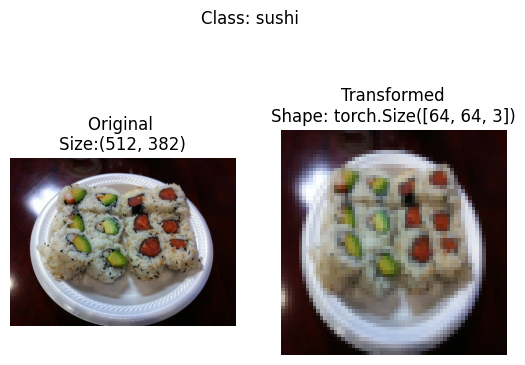

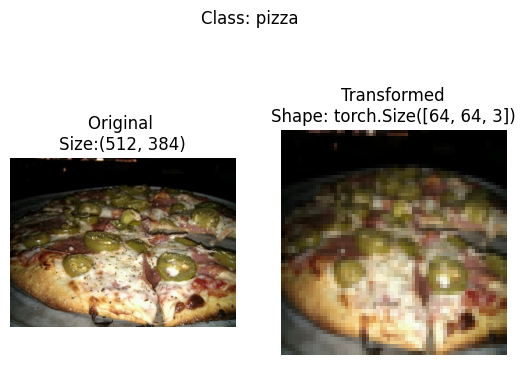

In [10]:
plot_transformed_images(image_path_list, data_transform)

### 3. Load-in all data

#### 1. With ImageFolder

In [11]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)
class_names = train_data.classes

Text(0.5, 1.0, 'pizza')

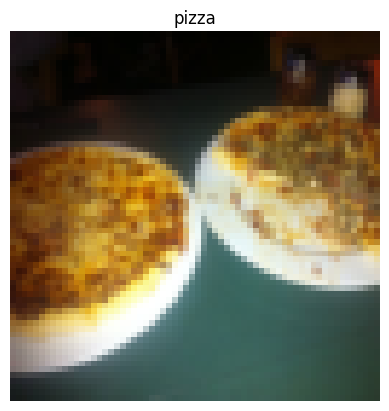

In [12]:
# Plot sample image
plt.figure()
plt.imshow(train_data[0][0].permute(1,2,0))
plt.axis(False)
plt.title(class_names[train_data[0][1]])

In [13]:
# Turn datasets into DataLoaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)
test_dataloader= DataLoader(dataset=test_data,
                            batch_size=BATCH_SIZE,
                            num_workers=os.cpu_count(),
                            shuffle=False)

#### 2. With custom dataset

In [14]:
# Build a function to replicate this ->
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [15]:
# Set up target directory
target_dir = train_dir
print(f"Target directory: {target_dir}")

# Get class names from target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_dir))])
class_names_found

Target directory: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [16]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory} ...")
  class2idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class2idx

In [17]:
find_classes(target_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### 3. Create custom dataset

In [18]:
from torch.utils.data import Dataset
class ImageFolderCustom(Dataset):
  def __init__(self,
               targ_dir: str,
               transform=None):
    self.paths = list(Path(targ_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index:int):
    return Image.open(self.paths[index])
  def __len__(self):
    return len(self.paths)
  def __getitem__(self, index) -> Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    if self.transform:
      img = self.transform(img)

    class_idx = self.class_to_idx[self.paths[index].parent.name]
    return (img, class_idx)

In [19]:
# Create a transform
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

# Test ImageFolderCustom
train_data_custom = ImageFolderCustom(train_dir, train_transforms)
test_data_custom = ImageFolderCustom(test_dir, test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7c3a70f35180>,
 <__main__.ImageFolderCustom at 0x7c3a70f36d10>)

In [20]:
len(train_data), len(train_data_custom)

(225, 225)

In [21]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 4. Display random images

In [22]:
def display_rand_imgs(dataset: Dataset,
                      classes: List[str] = None,
                      n_imgs: int = 10,
                      display_shape: bool = True,
                      seed: int = 42):

  # Set seed and cap number of images to ten
  random.seed(seed)
  n_imgs = 10 if n_imgs > 10 else n_imgs

  # Plot n_imgs number of random images from dataset
  plt.figure(figsize=(16,8))
  rand_samples_idx = random.sample(range(len(dataset)), k=n_imgs)
  for i, target in enumerate(rand_samples_idx):
    img, lbl = dataset[target][0], dataset[target][1]
    # [channels, height, width] -> [height, width, channels]
    img = img.permute(1, 2, 0)
    plt.subplot(1, n_imgs, i+1)
    plt.imshow(img)
    plt.axis(False)
    if classes:
      m = f"Class: {classes[lbl]}"
      if display_shape:
        m += f"\nShape: {img.shape}"
    plt.title(m)


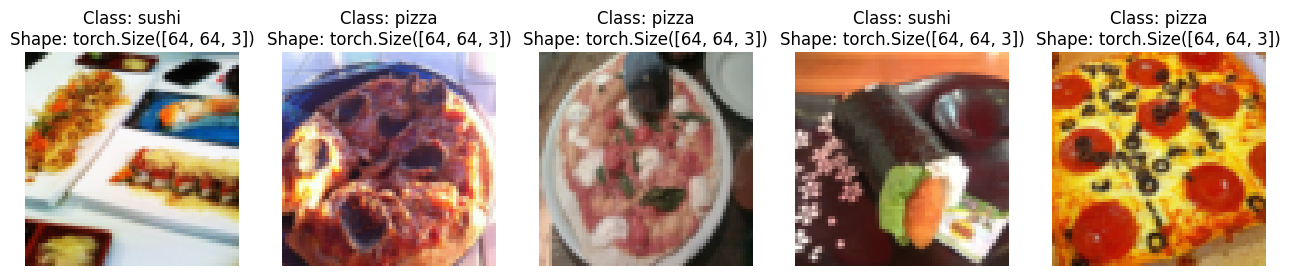

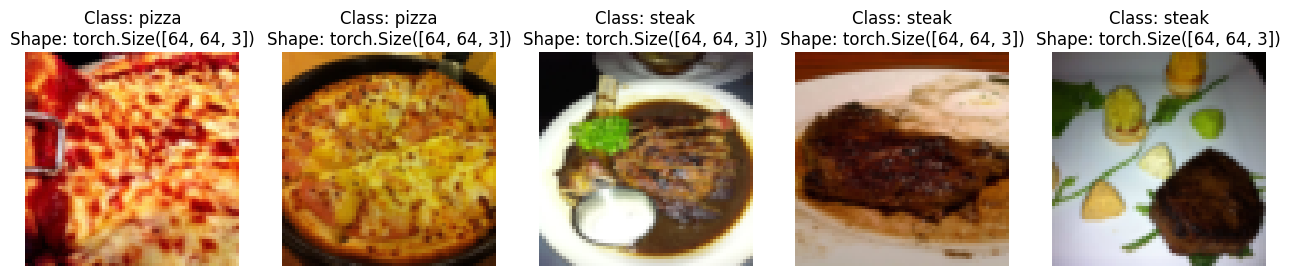

In [23]:
display_rand_imgs(dataset=train_data,
                  n_imgs=5,
                  classes=class_names)
display_rand_imgs(dataset=test_data,
                  n_imgs=5,
                  classes=class_names)

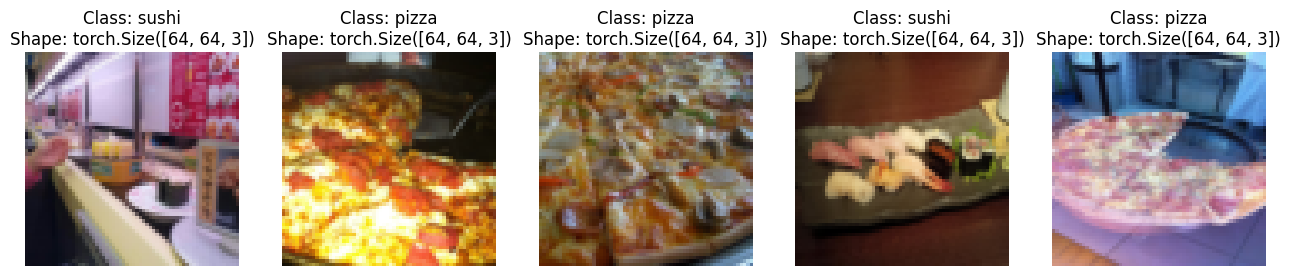

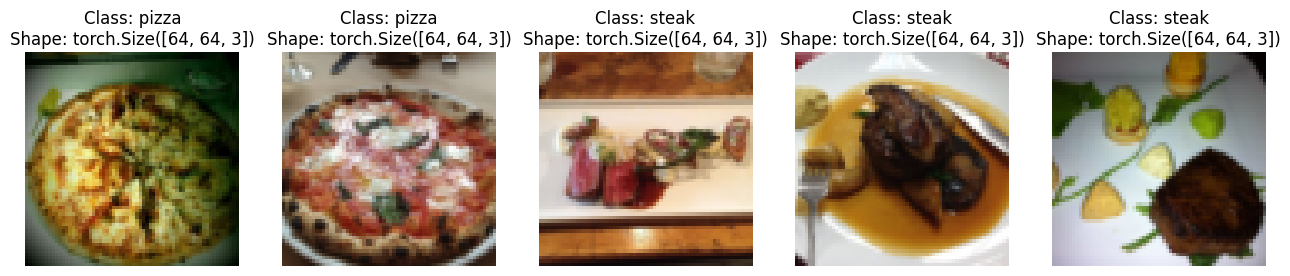

In [24]:
display_rand_imgs(dataset=train_data_custom,
                  n_imgs=5,
                  classes=class_names)
display_rand_imgs(dataset=test_data_custom,
                  n_imgs=5,
                  classes=class_names)

### 5. Turn custom loaded images into `DataLoader`

In [25]:
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                      batch_size=BATCH_SIZE,
                                      num_workers=os.cpu_count(),
                                      shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=os.cpu_count(),
                                    shuffle=False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7c3a70ad1c90>,
 <torch.utils.data.dataloader.DataLoader at 0x7c3a7071f730>)

In [26]:
# Get a sample
img, lbl = train_dataloader_custom = next(iter(train_dataloader_custom))
img.shape, lbl.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

### 6. Data Augmentation

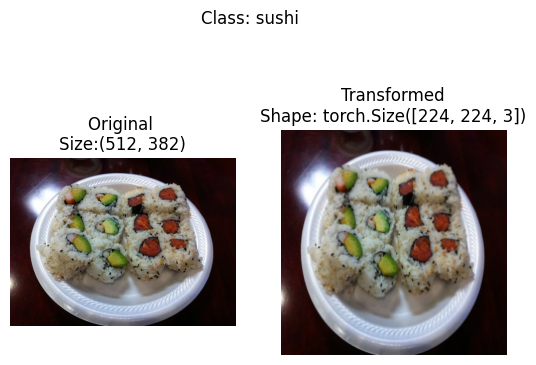

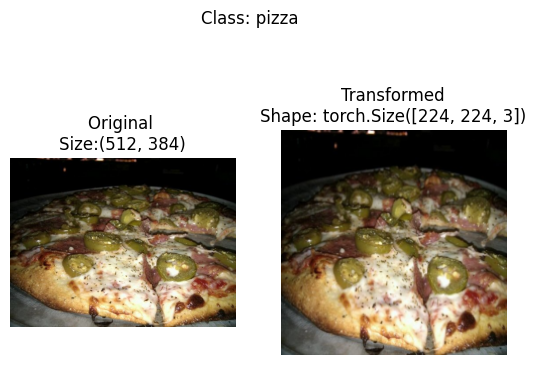

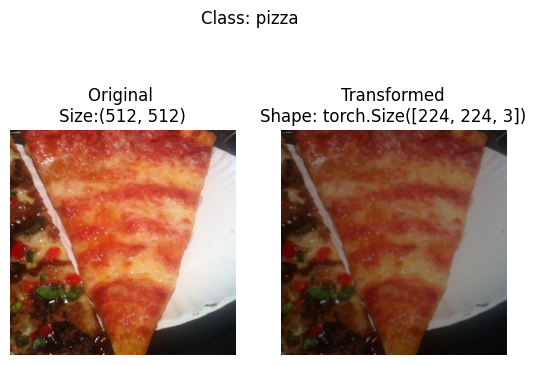

In [27]:
# Set up transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Plot random transformed images
plot_transformed_images(img_paths=image_path_list,
                        transform=train_transform,
                        n=3,
                        seed=42)

## 1. Define `train_step()`, `test_step()`, `train()`, and `plot_loss_curves()`

In [28]:
def train_step(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device):

  model.train()
  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Compute average loss and accuracy per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

def test_step(model: nn.Module,
              dataloader: DataLoader,
              loss_fn: nn.Module,
              device):
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      test_loss += loss
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1),dim=-1)
      test_acc += (y_pred_class==y).sum().item()/len(y_pred)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc

def train(model: nn.Module,
          epochs: int,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          train_dataloader: DataLoader,
          test_dataloader: DataLoader,
          device):

  results = {"train_loss":[],
             "train_acc":[],
             "test_loss":[],
             "test_acc":[],
             "train_time":None}
  t0 = timer()
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model,
                                       train_dataloader,
                                       loss_fn,
                                       optimizer,
                                       device)
    test_loss, test_acc = test_step(model,
                                    test_dataloader,
                                    loss_fn,
                                    device)
    # Update results per epoch
    results["train_loss"].append(train_loss.to("cpu").detach().numpy())
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss.to("cpu").detach().numpy())
    results["test_acc"].append(test_acc)

    log = f"Epoch: {epoch} | " \
          f"Train loss: {train_loss:.4f} | Train acc: {train_acc*100:.2f}% " \
          f"Test loss: {test_loss:.4f} | Test acc: {test_acc*100:.2f}%"
    print(log)

  t1 = timer()
  results["train_time"] = t1 - t0
  print(f"Training time: {t1 - t0:.3f} seconds")

  return results

def plot_loss_curves(results):
  epochs = range(len(results["train_loss"]))
  # Loss
  plt.figure(figsize=(15,7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, results["train_loss"], label="Train")
  plt.plot(epochs, results["test_loss"], label="Test")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, results["train_acc"], label="Train")
  plt.plot(epochs, results["test_acc"], label="Test")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

## 2. `model_0`: TinyVGG (baseline)

### 1. Create model class

In [29]:
class TinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    # *
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )
  def forward(self, x):
    return self.classifier(
        self.conv_block_2(
            self.conv_block_1(x)))

* in_features in `self.classifier` might be boring to calculate, try a forward pass and let the error tell the right shape

```
# Create a model
torch.manual_seed(SEED)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=8,
                  output_shape=len(class_names)).to(device)
img_batch, lbl_batch = next(iter(train_dataloader))
model_0(img_batch.to(device))

Output:
---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
<ipython-input-73-a1fdc362d84f> in <cell line: 7>()
      5                   output_shape=len(class_names)).to(device)
      6 img_batch, lbl_batch = next(iter(train_dataloader))
----> 7 model_0(img_batch.to(device))

8 frames
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/linear.py in forward(self, input)
    114
    115     def forward(self, input: Tensor) -> Tensor:
--> 116         return F.linear(input, self.weight, self.bias)
    117
    118     def extra_repr(self) -> str:

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1352 and 2048x3)
```

### 2. Train

In [30]:
SEED = 42
EPOCHS = 5
BATCH_SIZE = 32
IMG_SIZE = (64, 64)
NUM_WORKERS = os.cpu_count()

# Create transform
simple_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])

# Load image data
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=simple_transform)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=simple_transform)

# Turn datasets into DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

# Create and train a model
torch.manual_seed(SEED)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters())

model_0_results = train(model_0,
                        EPOCHS,
                        loss_fn,
                        optimizer,
                        train_dataloader,
                        test_dataloader,
                        device)

summary(model_0, input_size=[BATCH_SIZE, 3, 64, 64])

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063 | Train acc: 30.47% Test loss: 1.0983 | Test acc: 30.11%
Epoch: 1 | Train loss: 1.0998 | Train acc: 32.81% Test loss: 1.0697 | Test acc: 54.17%
Epoch: 2 | Train loss: 1.0869 | Train acc: 48.83% Test loss: 1.0807 | Test acc: 49.24%
Epoch: 3 | Train loss: 1.0843 | Train acc: 40.23% Test loss: 1.0608 | Test acc: 58.33%
Epoch: 4 | Train loss: 1.0662 | Train acc: 41.02% Test loss: 1.0656 | Test acc: 56.44%
Training time: 17.009 seconds


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

### 3. Plot loss curves

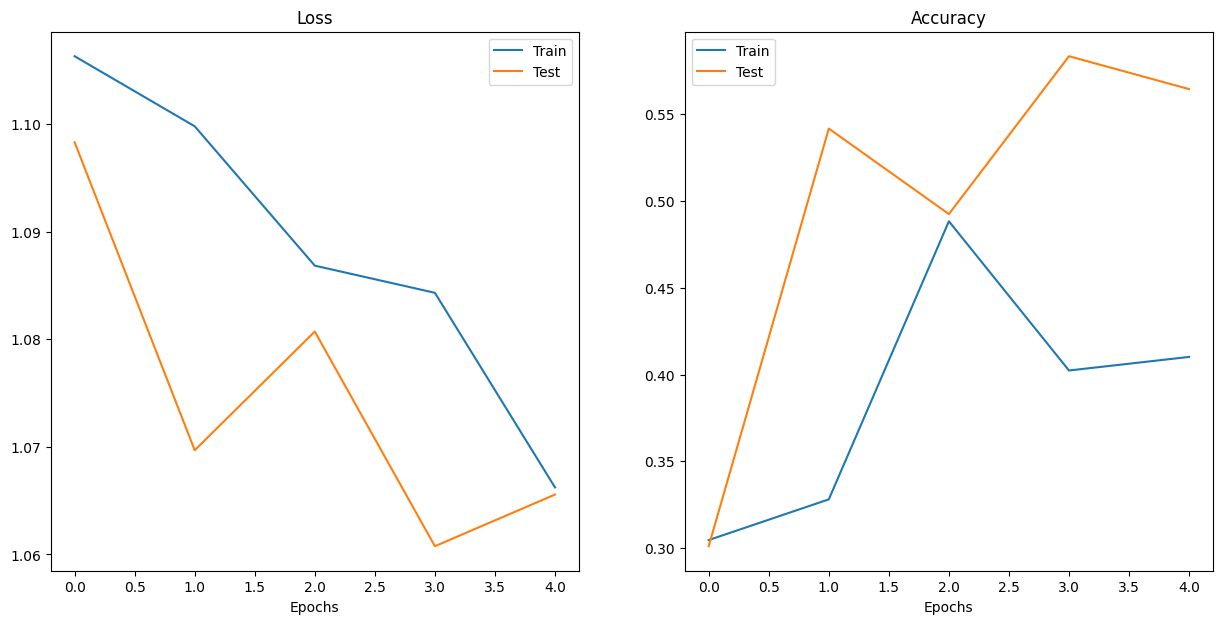

In [31]:
plot_loss_curves(model_0_results)

## 3. `model_1`: TinyVGG with Data Augmentation

### 1. Train

In [32]:
SEED = 42
EPOCHS = 5
BATCH_SIZE = 32
IMG_SIZE = (64, 64)
NUM_WORKERS = os.cpu_count()

# Create transform
train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
    ])

# Load image data
train_data = datasets.ImageFolder(train_dir, train_transform)
test_data = datasets.ImageFolder(test_dir, test_transform)

# Turn datasets into DataLoaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

# Create and train a model
torch.manual_seed(SEED); torch.cuda.manual_seed(SEED)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters())

model_1_results = train(model_1, EPOCHS, loss_fn, optimizer,
                        train_dataloader, test_dataloader, device)
summary(model_1, input_size=[BATCH_SIZE, 3, 64, 64])

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1069 | Train acc: 30.47% Test loss: 1.0993 | Test acc: 27.08%
Epoch: 1 | Train loss: 1.1019 | Train acc: 32.03% Test loss: 1.0719 | Test acc: 54.17%
Epoch: 2 | Train loss: 1.0917 | Train acc: 43.75% Test loss: 1.0846 | Test acc: 49.24%
Epoch: 3 | Train loss: 1.0915 | Train acc: 31.25% Test loss: 1.0678 | Test acc: 58.33%
Epoch: 4 | Train loss: 1.0862 | Train acc: 35.55% Test loss: 1.0750 | Test acc: 53.31%
Training time: 13.740 seconds


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

### 2. Plot loss curves

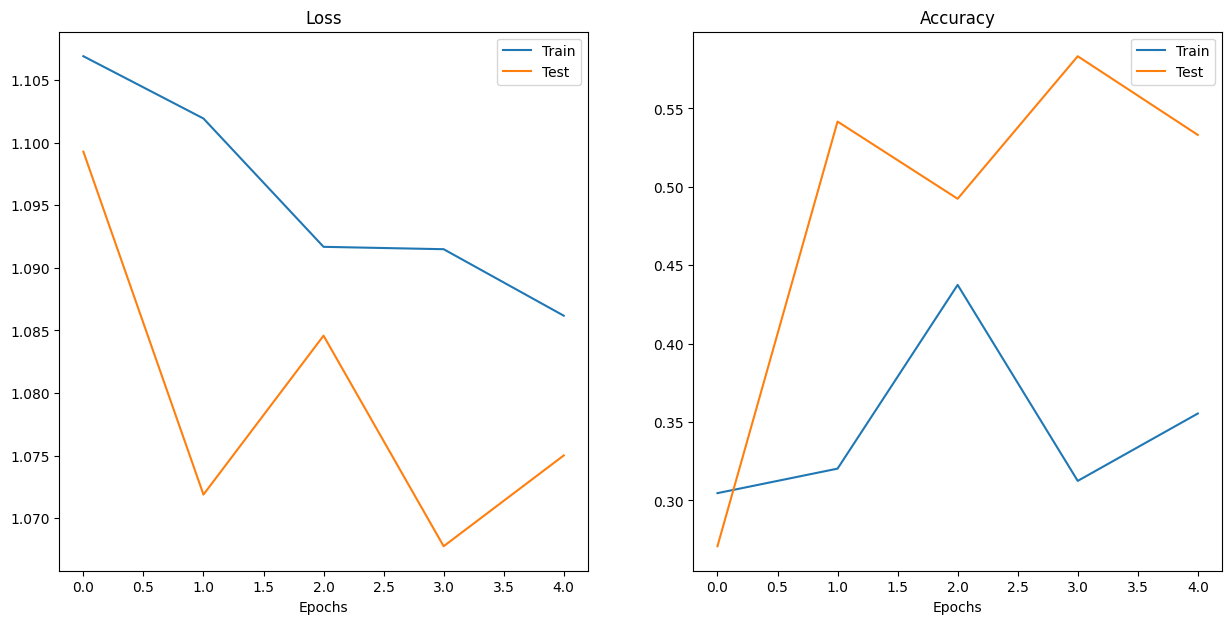

In [33]:
plot_loss_curves(model_1_results)

## 4. Compare models

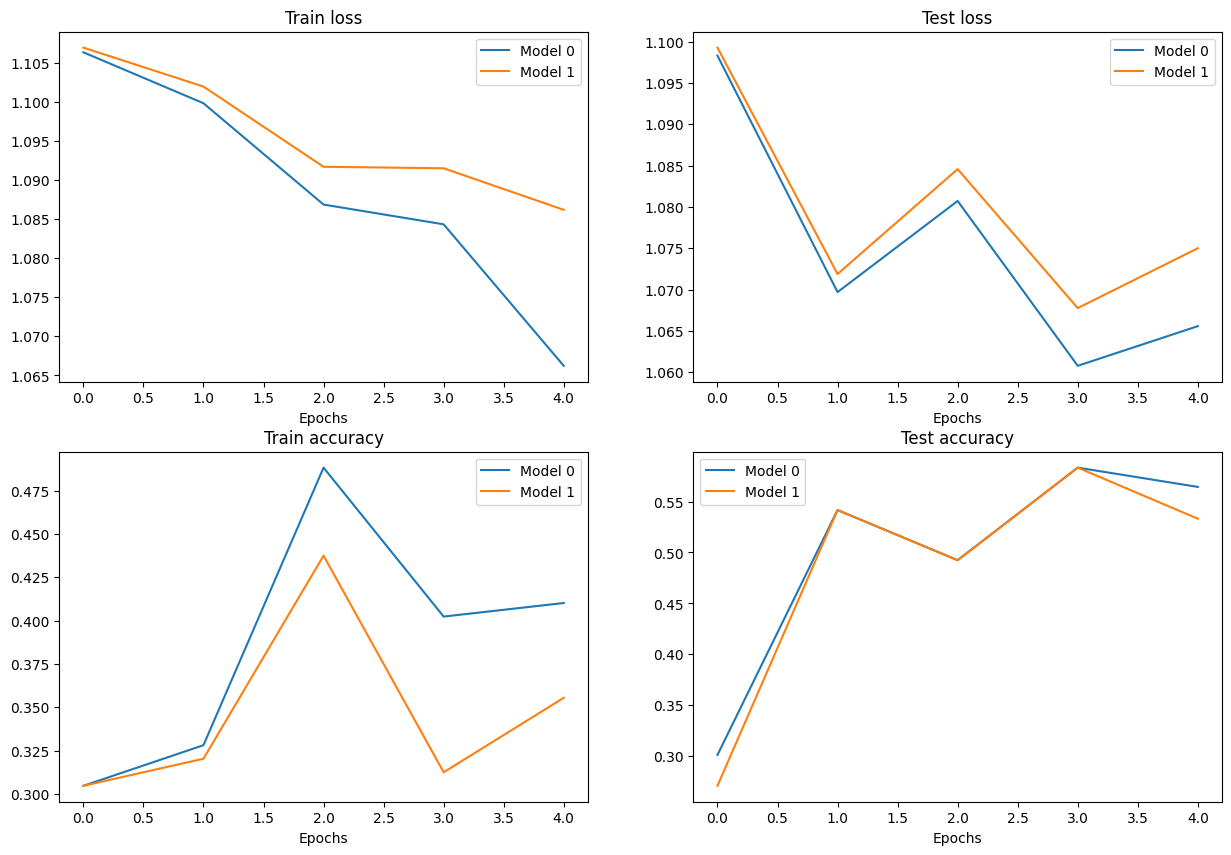

In [38]:
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

plt.figure(figsize=(15,10))
epochs = range(len(model_0_df))

plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train accuracy")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test accuracy")
plt.xlabel("Epochs")
plt.legend()

## 5. Make predictions

In [41]:
custom_img_path = data_path / "04-pizza-dad.jpeg"
if not custom_img_path.is_file():
  with open(custom_img_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    f.write(request.content)

In [95]:
def predict(model: nn.Module,
            device,
            class_names,
            img_shape,
            img= None,
            img_path= None):

  # Load image
  if img_path:
    img = torchvision.io.read_image(str(img_path)).type(torch.float32)/255

  log = f"Loaded image shape: {img.shape}"
  plt.imshow(img.permute(1, 2, 0))
  plt.axis(False)

  # Preprocess Image
  img = transforms.Resize(img_shape)(img)
  log += f"\nPreprocesed image shape: {img.shape}"

  # Predict
  model.to(device)
  model.eval()
  with torch.inference_mode():
    pred = model(img.unsqueeze(0).to(device))
    prob = torch.softmax(pred, dim=1)
    pred_class = class_names[torch.argmax(prob, dim=1)]

  plt.title(f"Class: {pred_class} | Prob: {prob.max():.2f}")

  # Print log
  print(log)

Loaded image shape: torch.Size([3, 4032, 3024])
Preprocesed image shape: torch.Size([3, 64, 64])


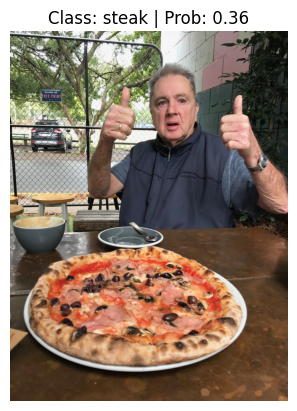

In [96]:
predict(model_0, device, class_names, (64, 64), img_path=custom_img_path)

Loaded image shape: torch.Size([3, 4032, 3024])
Preprocesed image shape: torch.Size([3, 64, 64])


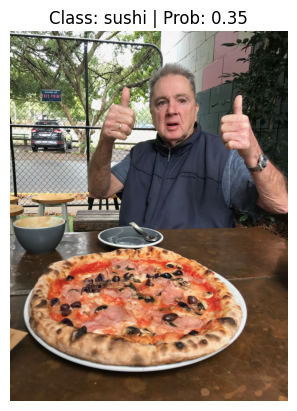

In [97]:
predict(model_1, device, class_names, (64, 64), img_path=custom_img_path)